# Train segmentation model for softgel capsules

## Imports and configuration

In [1]:
import shutil

from py7zr import pack_7zarchive, unpack_7zarchive
from fastai.data.external import untar_data
from fastai.data.transforms import get_image_files
from fastai.vision.data import SegmentationDataLoaders
from fastai.vision.learner import unet_learner
from fastai.vision.models import resnet18
from PIL import Image

In [2]:
shutil.register_archive_format(
    '7zip', pack_7zarchive, description='7zip archive')
shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)

In [3]:
SENSUM_SODF = "https://www.sensum.eu/resources/SensumSODF.7z"

## Download data

In [4]:
path = untar_data(SENSUM_SODF)

In [5]:
path.ls()

(#4) [Path('/Users/fpe/.fastai/data/SensumSODF/capsule'),Path('/Users/fpe/.fastai/data/SensumSODF/readme.txt'),Path('/Users/fpe/.fastai/data/SensumSODF/license.txt'),Path('/Users/fpe/.fastai/data/SensumSODF/softgel')]

In [6]:
(path/"softgel").ls()

(#2) [Path('/Users/fpe/.fastai/data/SensumSODF/softgel/positive'),Path('/Users/fpe/.fastai/data/SensumSODF/softgel/negative')]

In [7]:
(path/"softgel/positive").ls()

(#2) [Path('/Users/fpe/.fastai/data/SensumSODF/softgel/positive/annotation'),Path('/Users/fpe/.fastai/data/SensumSODF/softgel/positive/data')]

In [8]:
(path/"softgel/negative").ls()

(#2) [Path('/Users/fpe/.fastai/data/SensumSODF/softgel/negative/annotation'),Path('/Users/fpe/.fastai/data/SensumSODF/softgel/negative/data')]

## Create data loader

In [9]:
pos_fnames = get_image_files(path/"softgel/positive/data")

In [10]:
pos_fnames[0]

Path('/Users/fpe/.fastai/data/SensumSODF/softgel/positive/data/176.png')

In [11]:
neg_fnames = get_image_files(path/"softgel/negative/data")

In [12]:
neg_fnames[0]

Path('/Users/fpe/.fastai/data/SensumSODF/softgel/negative/data/348.png')

In [13]:
def label_func(fn):
    image_class = str(fn).split("/")[-3]
    if image_class == "positive":
        return path/f"softgel/positive/annotation/{fn.stem}{fn.suffix}"
    else:
        neg_masks_path = path/"softgel/negative/annotation"
        neg_masks_path.mkdir(exist_ok=True)
        mask_path = neg_masks_path/f"{fn.stem}{fn.suffix}"
        if mask_path.exists():
            return mask_path
        else:
            img = Image.open(fn)
            mask = Image.new("RGB", img.size)
            mask.save(mask_path)
            return mask_path

In [14]:
fnames = pos_fnames + neg_fnames

In [15]:
dls = SegmentationDataLoaders.from_label_func(path, bs=8, fnames=fnames, label_func=label_func, codes=["no_defect", "defect"])

/Users/fpe/code/ml/capsule-inspection/.venv/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


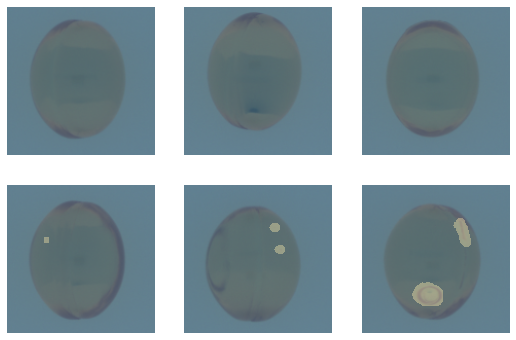

In [16]:
dls.show_batch(max_n=6)

## Train model

In [17]:
learner = unet_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/fpe/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/Users/fpe/code/ml/capsule-inspection/.venv/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [25]:
learner.fit(1)

[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

KeyboardInterrupt: 

In [28]:
??learner.save